In [2]:
import keras
from keras.models import Sequential
from keras.layers import Reshape
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping
from keras.regularizers import l2
from keras.layers import average 
from keras.models import Input, Model
from sklearn import metrics as mt
from matplotlib import pyplot as plt
from skimage.io import imshow
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, accuracy_score
from copy import deepcopy
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from copy import deepcopy
from keras.regularizers import l2
from keras.layers.normalization import BatchNormalization
from keras.layers import Add
from keras import optimizers
from matplotlib import pyplot as plt
import pickle
import numpy as np
from sklearn.metrics import roc_curve, auc
from scipy import interp
from sklearn.linear_model import LogisticRegression as SKLR
import itertools
%matplotlib inline

<h1>Preparation</h1>
<h2>The CIFAR-10 Dataset</h2>
<h3>Overview</h3>
<p>
The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images. The dataset is divided into five training batches and one test batch, each with 10000 images. The test batch contains exactly 1000 randomly-selected images from each class. The training batches contain the remaining images in random order, but some training batches may contain more images from one class than another. Between them, the training batches contain exactly 5000 images from each class. 
</p>

<p>
    <ul>
        <li>Airplane</li>
        <li>Automobile</li>
        <li>Bird</li>
        <li>Cat</li>
        <li>Deer</li>
        <li>Dog</li>
        <li>Frog</li>
        <li>Horse</li>
        <li>Ship</li>
        <li>Truck</li>
    </ul>
</p>

<p>The classes are completely mutually exclusive. There is no overlap between automobiles and trucks. "Automobile" includes sedans, SUVs, things of that sort. "Truck" includes only big trucks. Neither includes pickup trucks.</p>

<h3>Purpose of the Dataset</h3>
<p>To train machine learning and computer vision algorithms, as these algorithms learn to recognize objects in images by example.</p>
<h3>Why was the data collected in the first place?</h3>
<p>The data was collected by the Canadian Institute for Advanced Research (CIFAR). It is a labeled subset of the 80 million tiny images dataset. Students were paid to label those images. This dataset was built primarily for machine learning reasearch.</p>
<h3>Prediction Task</h3>
<p>The task is to be able to accurately classify the images by labels. There are 10 classes and labels in this dataset. As this dataset was primarily built for machine learning research, educational institutions and researchers would be most interested in this dataset to train and test their algorithms. The importance of this dataset lies in its versatility and simplicity; it is a clean dataset with a clear prediction task that can be used to train algorithms.</p>

<h3>Business Case: Once you begin modeling, how well would your prediction algorithm need to perform to be considered useful to the identified third parties</h3>
<p>A cloud image service like imgur could utilize an image classifer to classify every image that gets uploaded to their servers. Image classification could be important to exclude certain images from getting uploaded, as manually surfing through all uploaded images is inefficient and impractical. So it would function as a filter. It could also serve to classify the content of those images and assign a label for each. While this is a relatively small subset of images with a small number of classes (10), it would serve to test the performance of different prediction algorithms. Having said that, the prediction algorithm would need to be very accurate to be useful for those uses. A margin of 97% accuracy is selected in this case. Identifying a car as a frog is unacceptable, as an example.</p>

<h2>Reading and Processing the Images</h2>

In [3]:
# Loading (unpickling) the data for later processing
import numpy as np
import pickle
from matplotlib import pyplot as plt
%matplotlib inline
from sklearn.decomposition import PCA

def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dicts = pickle.load(fo, encoding='bytes')
        images = dicts[b'data']
        labels = dicts[b'labels']
        imageArray = np.array(images)
        labelArray = np.array(labels)
    return imageArray, labelArray

In [4]:
# These are the data and class labels (targets)
first_batch_images, first_batch_labels = unpickle('cifar-10-batches-py\data_batch_1')
second_batch_images, second_batch_labels = unpickle('cifar-10-batches-py\data_batch_2')
third_batch_images, third_batch_labels = unpickle('cifar-10-batches-py\data_batch_3')
fourth_batch_images, fourth_batch_labels = unpickle('cifar-10-batches-py\data_batch_4')
fifth_batch_images, fifth_batch_labels = unpickle('cifar-10-batches-py\data_batch_5')

images = np.vstack((first_batch_images, second_batch_images, third_batch_images, fourth_batch_images, fifth_batch_images))
y = np.vstack((first_batch_labels, second_batch_labels, third_batch_labels, fourth_batch_labels, fifth_batch_labels))
y = y.reshape((images.shape[0], 1))

In [5]:
# Each row in the images array represents one image
# The first 32x32 = 1024 values represent the red channel, the second 1024 values are for the green channel, and the final
# 1024 values represent the blue channel
# So we need to make them into 32x32x3 for later processing in Keras
# The images are expanded into the form (samples, image height, image width, channels) for later processing

width = 32
height = 32

labels = np.array(['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck'])
n_classes = len(labels)

<h2>Evaluation Metric</h2>
<p>As per my business case, which is image classification, accuracy is the evaluation metric I choose. I choose accuracy because:
<ul>
    <li>The image dataset is perfectly balanced; there's no class imbalance present in the dataset, so a simple evaluation metric such as accuracy would work perfectly well.</li>
    <li>There is no special importance assigned to the classification of any of the classes compared to the others. The cost of misclassification for all the classes is the same.</li>
    <li>The models that are yet to be modeled are meant as prototypes for deployable classification models, and accucracy is a good quantification of generalization performance for balanced data, so accuracy is the evaluation metric I choose for this dataset.</li>
</ul>

<h2>Data Division</h2>
<p>
    <ul>
        <li>The dataset will be split according to 80/20 for training/testing.</li>
        <li>Stratified K-Folding will be used on the 80% training dataset for cross validation. Stratified K-Folds are approproate because I want to make sure that each fold is a perfect representative of the overall training dataset. It is also a good way of dividing the data because the stream of images an implemented algorithm may receive will not be balanced in general.</li>
        <li>Finally, the model with the best statistical quantities resulting from the Grid Search will be tested using the untouched 20% of the images. Its performance in classifying those 20% of the images dictates its generalization performance.</li>
    </ul>
</p>

<h1>Modeling</h1>

<h2>Expansion of the Data</h2>
<p>I use the ImageDataGenerator class to produce augmented data with the following perturbations:</p>
<ul>
    <li>Rotation: 9 degrees range for random image rotations. This is appropriate for this dataset because it would decrease the chance of overfitting. It would also introduce the variability of similar features in the images, position-wise.</li>
    <li>Width: 15% for random width shift range.</li>
    <li>Height: 15% for random height shift range.</li>
    <li>Shear: 3 degrees for shear intensity in the counterclockwise direction. This would distort the images small enough to still be recognizable and large enough to prevent overfitting and introduce more variability.</li>
    <li>Zoom: Random zooming of the images in the range of [0.7 1.3]. This might introduce good variability in the image set.</li>
    <li>Horizontal Flipping: Random horizontal flipping of the images.</li>
    
</ul>

<h2>Evaluation</h2>
<p>The following function accepts an arbitrary number of models of convolutional neural networks and returns their histories, validation accuracies, and their testing accuracies.

<h3>Arguments</h3>
<ul>
    <li>Number of classes in the dataset.</li>
    <li>List of Keras models.</li>
    <li>An images array.</li>
    <li>Image labels (targets).</li>
    <li>Keras loss function.</li>
    <li>Keras optimizer.</li>
    <li>Number of images we want to work with, if not the whole dataset.</li>
    <li>Size of the test portion of the data.</li>
    <li>Number of stratified folds (K).</li>
    <li>Epochs per fold evaluation.</li>
    <li>Batch size.</li>
</ul>
<h3>Processing</h3>

<p>First, the function shuffles the images array. Then, it slices the amount of images needed as dictated by the amount specified in the function call, transform them to greyscale, normalize them, expand them into tensors for Keras, one-hot-encode the target array, and then split the images and their labels according to 80/20 for training and testing. Following this, the 80% are used in a stratified k-folding scheme where the training portion is fed to a data generator to generate augmented images perturbed in various ways, and then the data is fed sequentially to each of the compiled Keras models in a for loop for fitting. Then, the validation portion of the k-folding and the testing portion are used to produce validation and testing accuracies for each of the models, which are then saved. At the end of the last fold, the function returns the models' histories, validation accuracies, and testing accuracies, which are then utilized for statistical comparisons.
</p>

In [19]:
def cifarConv(n_classes, convnns, images, image_labels, lossf, optim, image_count = 2500, 
              test_size = 0.2, validation_splits = 10, epo = 5, batchSize = 128):

    width = 32
    height = 32
    test_accus = []
    validation_accus = []
    histories = []

    # I shuffle the images of the dataset for later selection here
    images_array = np.hstack((images, image_labels.reshape((images.shape[0], 1))))
    np.random.shuffle(images_array)
    images, image_labels = images_array[0:image_count, :-1].astype('float32'), images_array[0:image_count, -1].astype(int)
    # The proc_images array holds the grayscaled images that were randomly shuffled in the previous step
    proc_images = np.zeros((image_count, width*height))
    # Conversion to grayscale
    for image_idx in range(image_count):
        for i in range(width*height):
            proc_images[image_idx, i] = 0.3*images[image_idx, i] +  0.59*images[image_idx, i + 1024] + 0.11*images[image_idx, i + 2048]    
    # Normalization
    images = proc_images/255
    # Expanding the images into tensors that Keras understands
    images = np.expand_dims(images.reshape((-1, width, height)), axis = 3)
    # One-hot-encoding the image labels
    image_labels_ohe = keras.utils.to_categorical(image_labels, n_classes)
    # Splitting the images to 80% training images and 20% testing images
    X_train, X_test, y_train, y_test = train_test_split(images, image_labels_ohe, test_size = test_size)
    # Stratify-splitting the 80% training images
            
    cv = StratifiedKFold(n_splits = validation_splits)
    # Looping through the k-splits
    for train, validation in cv.split(X_train, np.zeros(shape=(X_train.shape[0], 1))):
        
        k_x_train, k_x_validation = X_train[train], X_train[validation]
        k_y_train, k_y_validation = y_train[train], y_train[validation]
    # Data generator representing the aforementioned augmentation scheme    
        data_generator = ImageDataGenerator(

            featurewise_center=False,
            samplewise_center=False,
            featurewise_std_normalization=False,
            samplewise_std_normalization=False,
            zca_whitening=False,
            rotation_range=9,
            width_shift_range=0.15,
            height_shift_range=0.15,
            shear_range=3.0,
            zoom_range=0.3,
            channel_shift_range=0.,
            fill_mode='nearest',
            cval=0.,
            horizontal_flip=True,
            vertical_flip=False,
            rescale=None)        
        # Fitting the training data with the defined data generator
        data_generator.fit(k_x_train)
        # Cloning the CNN models passed to the function
        cnns = []    
        fold_models_test_accus = []
        fold_models_histories = []
        fold_models_validation_accus = []
        
        for i in range(len(convnns)):
            fold_models_histories.append(0)
        # Cloning the CNN Models
        for cn in convnns:
            cnn = keras.models.clone_model(cn)
            cnn.compile(loss=lossf, optimizer=optim, metrics=['accuracy'])
            cnns.append(cnn)
        # Fitting the models using the same k-folds
        for i in range(len(cnns)):
            fold_models_histories[i] = cnns[i].fit_generator(data_generator.flow(k_x_train, k_y_train, batch_size=batchSize), 
                       steps_per_epoch=int(len(k_x_train)/batchSize),
                       epochs=epo, 
                       verbose=1)
        # Saving the models' fold histories    
        histories.append(np.array(fold_models_histories))
        
        # Fold test and validation accuracies for all the CNN models
        for i in range(len(cnns)):
            yhat_test = np.argmax(cnns[i].predict(X_test), axis=1)
            yhat_validation = np.argmax(cnns[i].predict(k_x_validation), axis=1)
            
            y_test_int = np.argmax(y_test, axis=1)
            y_validation_int = np.argmax(k_y_validation, axis=1)
            
            test_acc = accuracy_score(y_test_int, yhat_test)
            validation_acc = accuracy_score(y_validation_int, yhat_validation)
            
            fold_models_validation_accus.append(validation_acc)
            fold_models_test_accus.append(test_acc)
        # Test and validation accuracies for all folds
        test_accus.append(np.array(fold_models_test_accus))
        validation_accus.append(fold_models_validation_accus)
                        
    return histories, validation_accus, test_accus

<h2>Architectures</h2>
<h3>First CNN Architecture</h3>
<p>My first CNN will have the following shape:</p>
<ol>
    <li>Convolutional input layer with 32 filters, 3x3 kernel size, and a RELU activation function.</li>
    <li>Convolutional input layer with 48 filters, 3x3 kernel size, and a RELU activation function.</li>
    <li>Convolutional input layer with 64 filters, 3x3 kernel size, and a RELU activation function.</li>
    <li>Max-pool layer with size 2x2.</li>
    <li>Addition of 25% dropout.</li>
    <li>Convolutional input layer with 64 filters, 3x3 kernel size, and a RELU activation function.</li>
    <li>Convolutional input layer with 64 filters, 3x3 kernel size, and a RELU activation function.</li>
    <li>Max-pool layer with size 2x2.</li>
    <li>Addition of 25% dropout.</li>
    <li>Addition of a flattening layer.</li>
    <li>Densing through a 384 neurons layer with a RELU activation function.</li>
    <li>Addition of 50% dropout.</li>
    <li>Densing through a layer with 10 neurons to produce the output predictions through a softmax activation function.</li>
</ol>

<p>This architecture applies L2-Regularization, utilizes the rmsprop optimizer and the categorical cross entropy loss function.</p>

In [25]:
def cnn1(l2_lambda = 0.0000001, f1 = 32):
    cnn1 = Sequential()

    cnn1.add(Conv2D(filters=f1,
                    input_shape = (width,height,1),
                    kernel_size=(3,3), 
                    padding='same', 
                    kernel_regularizer=l2(l2_lambda),
                    activation='relu'))

    cnn1.add(Conv2D(filters=48,
                    kernel_size=(3,3), 
                    padding='same', 
                    kernel_regularizer=l2(l2_lambda),
                    activation='relu'))

    cnn1.add(Conv2D(filters=64,
                    kernel_size=(3,3), 
                    kernel_regularizer=l2(l2_lambda),
                    padding='same', 
                    activation='relu'))

    cnn1.add(MaxPooling2D(pool_size=(2, 2), data_format="channels_last"))

    cnn1.add(Dropout(0.25))

    cnn1.add(Conv2D(filters=64,
                    kernel_size=(3,3),
                    kernel_regularizer=l2(l2_lambda),
                    padding='same', 
                    activation='relu'))

    cnn1.add(Conv2D(filters=64,
                    input_shape = (width,height,1),
                    kernel_size=(3,3), 
                    kernel_regularizer=l2(l2_lambda),
                    padding='same', 
                    activation='relu'))

    cnn1.add(MaxPooling2D(pool_size=(2, 2), data_format="channels_last"))

    cnn1.add(Dropout(0.25))

    cnn1.add(Flatten())

    cnn1.add(Dense(512, activation='relu', kernel_regularizer=l2(l2_lambda)))
    cnn1.add(Dropout(0.5))
    cnn1.add(Dense(n_classes, activation='softmax', kernel_regularizer=l2(l2_lambda)))
    return cnn1

<h3>ResNet Style Architecure</h3>
<p>My second CNN will have the following shape:</p>
<ol>
    <li>Convolutional input layer with 64 filters, 3x3 kernel size, and a RELU activation function.</li>
    <li>Convolutional input layer with 64 filters, 3x3 kernel size, and a RELU activation function.</li>
    <li>Max-pool layer with size 2x2.</li>
    <li>Convolutional input layer with 64 filters, 3x3 kernel size, and a RELU activation function.</li>
    <li>Convolutional input layer with 64 filters, 3x3 kernel size, and a RELU activation function.</li>
    <li>Addition of the last output with the previous max-pool layer.</li>
    <li>Activation through RELU.</li>
    <li>Convolutional input layer with 128 filters, 3x3 kernel size, and a RELU activation function.</li>
    <li>Convolutional input layer with 128 filters, 3x3 kernel size, and a RELU activation function.</li>
    <li>Max-pool layer with size 2x2.</li>
    <li>Convolutional input layer with 128 filters, 3x3 kernel size, and a RELU activation function.</li>
    <li>Convolutional input layer with 128 filters, 3x3 kernel size, and a RELU activation function.</li>
    <li>Addition of the last output with the previous max-pool layer.</li>
    <li>Activation through RELU.</li>
    <li>Max-pool layer with size 2x2.</li>
    <li>Flattening layer.</li>
    <li>Addition of 25%% dropout.</li>
    <li>Densing through a 384 neurons layer with a RELU activation function.</li>
     <li>Addition of 50% dropout.</li>
    <li>Densing through a layer with 10 neurons to produce the output predictions through a softmax activation function.</li>
</ol>

<p>This architecture applies L2-Regularization, utilizes the SGD optimizer with momentum, and uses the categroical cross-entropy loss function.</p>

In [14]:
# This model has been adapted from the professor's notebook
def cnn2(l2_lambda = 0.0000001, f1 = 64):
    input_holder = Input(shape=(width, height, 1))

    x = Conv2D(filters=f1,
                   input_shape = (width,height,1),
                   kernel_size=(3,3),
                   kernel_initializer='he_uniform', 
                   kernel_regularizer=l2(l2_lambda),
                   padding='same', 
                   activation='relu', 
                   data_format="channels_last")(input_holder)

    x = Conv2D(filters=64,
                   kernel_size=(3,3),
                   kernel_initializer='he_uniform', 
                   kernel_regularizer=l2(l2_lambda),
                   padding='same', 
                   activation='relu', 
                   data_format="channels_last")(x)

    x1 = MaxPooling2D(pool_size=(2, 2), data_format="channels_last")(x)

    x = Conv2D(filters=64,
                   kernel_size=(3,3),
                   kernel_initializer='he_uniform', 
                   kernel_regularizer=l2(l2_lambda),
                   padding='same', 
                   activation='relu', 
                   data_format="channels_last")(x1)


    x = Conv2D(filters=64,
                   kernel_size=(3,3),
                   kernel_initializer='he_uniform', 
                   kernel_regularizer=l2(l2_lambda),
                   padding='same', 
                   activation='relu', 
                   data_format="channels_last")(x)

    x = Add()([x, x1])
    x = Activation("relu")(x)

    x = Conv2D(filters=128,
                   kernel_size=(3,3),
                   kernel_initializer='he_uniform', 
                   kernel_regularizer=l2(l2_lambda),
                   padding='same', 
                   activation='relu', 
                   data_format="channels_last")(x)

    x = Conv2D(filters=128,
                   kernel_size=(3,3),
                   kernel_initializer='he_uniform', 
                   kernel_regularizer=l2(l2_lambda),
                   padding='same', 
                   activation='relu', 
                   data_format="channels_last")(x)

    x2 = MaxPooling2D(pool_size=(2, 2), data_format="channels_last")(x)

    x = Conv2D(filters=128,
                   kernel_size=(3,3),
                   kernel_initializer='he_uniform', 
                   kernel_regularizer=l2(l2_lambda),
                   padding='same', 
                   activation='relu', 
                   data_format="channels_last")(x2)


    x = Conv2D(filters=128,
                   kernel_size=(1,1),
                   kernel_initializer='he_uniform', 
                   kernel_regularizer=l2(l2_lambda),
                   padding='same', 
                   activation='relu', 
                   data_format="channels_last")(x)


    x = Add()([x, x2])
    x = Activation("relu")(x)

    x = MaxPooling2D(pool_size=(2, 2), data_format="channels_last")(x)

    x = Flatten()(x)
    x = Dropout(0.25)(x)
    x = Dense(256)(x)
    x = Activation("relu")(x)
    x = Dropout(0.5)(x)
    x = Dense(n_classes)(x)
    x = Activation('softmax')(x)

    resnet = Model(inputs=input_holder, outputs=x)
    return resnet

<h3>Evaluation</h3>
<p>The following 4 models will be used in the analysis to follow. Those are the specifics of the evaluation for the 4 models:
<ul>
    <li>Categorical Cross-Entropy was used as a loss function.</li>
    <li>RMSPROP was used as an optimizer.</li>
    <li>Only 2000 images were used in this evaluation. Evaluating for the whole dataset for those 4 models for 5 folds would take 3 days, so I am evaluating for 2000 images in this analysis, and then for the whole dataset for the best model only.</li>
    <li>Test dataset size is 20% of the image count, as stated in the first section of the notebook.</li>
    <li>5 Folds for stratification.</li>
    <li>8 iterations (epochs) for each fold evaluation.</li>
    <li>Batch size of 32.</li>
</ul>
</p>

In [15]:
cnn1_64 = cnn1(l2_lambda = 0.0000001, f1 = 64) # This model represents the first architecture wit 64 filter first conv. layer
cnn1_16 = cnn1(l2_lambda = 0.0000001, f1 = 16) # This model represents the first architecture wit 16 filter first conv. layer
cnn2_64 = cnn2(l2_lambda = 0.0000001, f1 = 64) # This model represents the second architecture wit 64 filter first conv. layer
cnn2_16 = cnn2(l2_lambda = 0.0000001, f1 = 16) # This model represents the second architecture wit 16 filter first conv. layer

models = [cnn1_64, cnn1_16, cnn2_64, cnn2_16]

In [20]:
%%time
histories, val_accus, test_accus = cifarConv(n_classes,models, images, y, 'categorical_crossentropy', 'rmsprop', image_count = 2000, test_size = 0.2, validation_splits = 5, epo = 8, batchSize=32)

Epoch 1/8
40/40 [==============================] - 25s 622ms/step - loss: 2.3123 - acc: 0.1227
Epoch 2/8
40/40 [==============================] - 22s 562ms/step - loss: 2.2919 - acc: 0.1359
Epoch 3/8
40/40 [==============================] - 23s 583ms/step - loss: 2.2053 - acc: 0.1844
Epoch 4/8
40/40 [==============================] - 27s 670ms/step - loss: 2.1502 - acc: 0.2094
Epoch 5/8
40/40 [==============================] - 24s 588ms/step - loss: 2.0954 - acc: 0.2281
Epoch 6/8
40/40 [==============================] - 26s 638ms/step - loss: 2.0747 - acc: 0.2523
Epoch 7/8
40/40 [==============================] - 29s 714ms/step - loss: 2.0566 - acc: 0.2453
Epoch 8/8
40/40 [==============================] - 26s 641ms/step - loss: 2.0048 - acc: 0.2555
Epoch 1/8
40/40 [==============================] - 22s 550ms/step - loss: 2.3149 - acc: 0.0984
Epoch 2/8
40/40 [==============================] - 19s 483ms/step - loss: 2.2814 - acc: 0.1391
Epoch 3/8
40/40 [==============================] -

<h2>Training Accuracy, Validation Accuracy, Training Loss, and Testing Accuracy for the Four Models</h2>

<h3>Training and Validation Accuracies and Loss</h3>

<p>The code block below remaps the variables found from the function that trained the models (convcifar) to independent variables associated with the separate models. Then, the following function (summarize_data) is used to plot the training accuracy and training loss versus the epochs for each model. It also plots the validation accuracy vs the folds for each model.</p>

In [300]:
allModelsValAccus = []
allModelsHistories = []
allModelsTesAccus = []

for i in range(4):
    modelHistories = []
    modelValidationAccus = []
    modelTestAccu = []
    
    for j in range(5):
        modelValidationAccus.append(np.array(val_accus)[j, i])
        modelHistories.append(np.array(histories)[j, i])
        modelTestAccu.append(np.array(test_accus)[j, i])

    allModelsValAccus.append(np.array(modelValidationAccus))
    allModelsHistories.append(modelHistories)
    allModelsTesAccus.append(modelTestAccu)

In [297]:
def summarize_data(history, val_accu, model_num):
    c = 1
    rows = len(history)
    columns = 3

    plt.figure(figsize = (7*columns, 7*rows))
    
    plt.subplot(rows, columns, 1)
    plt.ylabel('Accuracy %')
    plt.title('Training Folds Accuracies For Model ' + model_num)
    for i, fold in enumerate(history):
        plt.plot(fold.history['acc'])


    plt.subplot(rows, columns, 2)
    plt.ylabel('Training Loss')
    plt.xlabel('epochs')
    plt.title('Training Folds Losses For Model ' + model_num)
    for i, fold in enumerate(history):
        plt.plot(fold.history['loss'])

    
    plt.subplot(rows, columns, 3)
    plt.plot(val_accu)
    plt.ylabel('Validation Accuracy over The 5 Folds For Model')
    plt.xlabel('Folds')
    plt.title('Validation Accuracy Vs. Folds For Model ' + model_num)

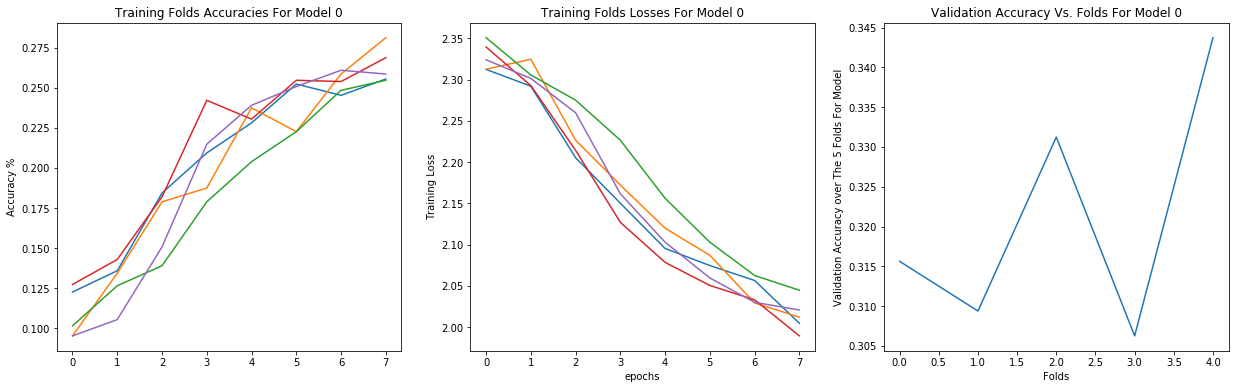

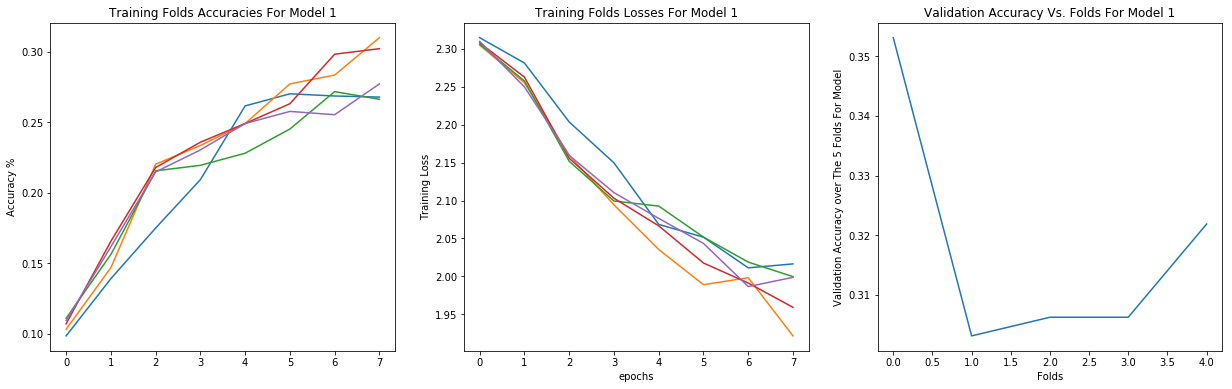

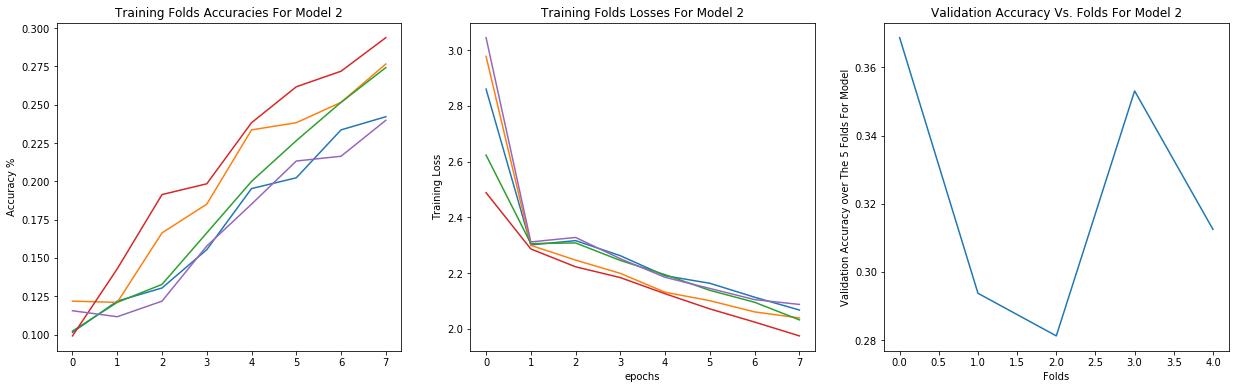

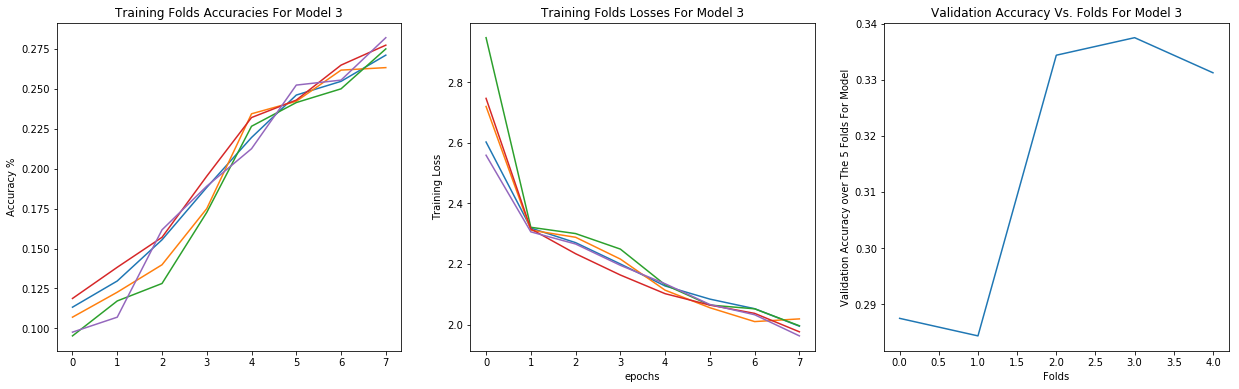

In [301]:
models = 4

for i in range(models):
    summarize_data(allModelsHistories[i], allModelsValAccus[i], str(i))

<p>The first and second sets of plots are of the first architecture defined above. The last two sets are of the resnet-style architecture defined above. Each architecture pair is similar in the shape of the training accuracy and loss curves. The five curves present in each plot represent the 5 folds used in the evaluation.</p>

<h3>Testing Accuracy for the Four Models</h3>
<p>The testing accuracy was evaluated at every fold evaluation for every model by the training function defined above. Here, I am going to plot the testing accuracy vs. the folds for all 4 models.</p>

In [315]:
def plot_test_accu(val_accu):
    c = 1
    rows = len(val_accu)
    columns = 4
    
    plt.figure(figsize = (6*columns, 7*rows))
    for i, modelAccu in enumerate(val_accu):
        plt.subplot(rows, columns, c)
        plt.plot(modelAccu)
        plt.ylabel('Testing Accuracy over The 5 Folds For Model ' + str(i))
        plt.xlabel('Folds')
        plt.title('Testing Accuracy Vs. Folds For Model ' + str(i))
        c += 1

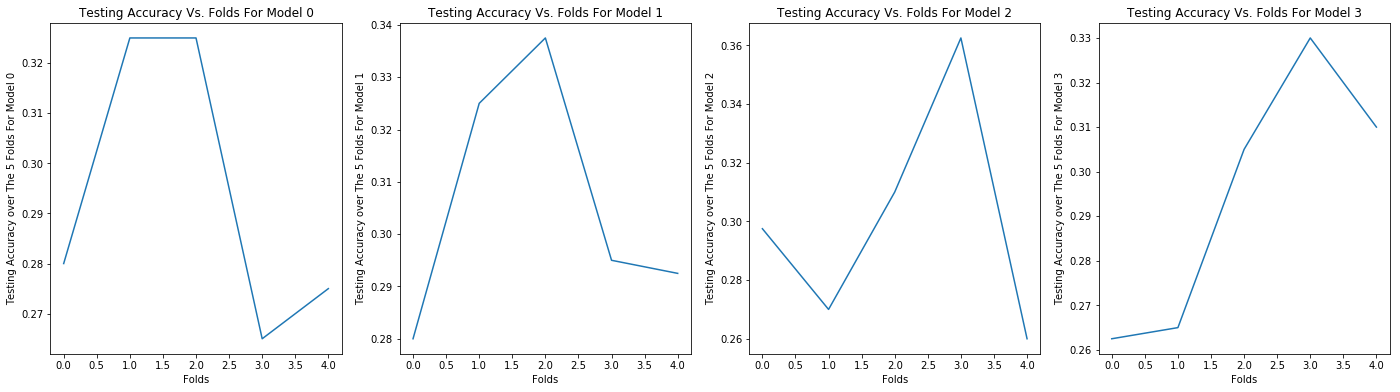

In [316]:
plot_test_accu(allModelsTesAccus)

<h2>Statistical Comparison For the Four Models</h2>

<p>I will be following those steps in deciding the best model:</p>
<ol>
    <li>I will evaluate the mean of the validation accuracies of the models among the folds versus the standard deviation of those accuracies. This will serve as a basic measure of the variability of the accuracy across the folds for each model. Ideally, I would have many more folds (5 in this analysis) to do this for, but I couldn't do more than 5 due the computational burden.</li>
    <li>The best two in terms of accuracy and STD will be picked out.</li>
    <li>The data in the folds is correlated with one another; they are not independent, therefore, I will be performing a t-test to see if we can say with confidence (say 90%) that one of the two models is statically better than the other.</li>
</ol>

In [338]:
mean_validation_accus = np.mean(allModelsValAccus, axis = 1)
stds_validation_accus = np.std(allModelsValAccus, axis = 1)

In [339]:
for i in range(len(mean_testing_accus)):
    print('The mean accuracy of model', i, 'is', "{0:.7f}".format(100*mean_validation_accus[i]),'% and the standard deviation is', "{0:.7f}".format(100*stds_validation_accus[i]),'%')

The mean accuracy of model 0 is 32.1250000 % and the standard deviation is 1.4169730 %
The mean accuracy of model 1 is 31.8125000 % and the standard deviation is 1.8687395 %
The mean accuracy of model 2 is 32.1875000 % and the standard deviation is 3.3773140 %
The mean accuracy of model 3 is 31.5000000 % and the standard deviation is 2.3832095 %


<p>Based on the mean accuracy and the standard deviation of the accuracies across the folds, the best two models are the first and second one. Now to perform the t-test on those models to decide which is better.</p>

In [351]:
# Number of Folds
k = 5
# Error Difference in the Validation Accuracies
d = (1 - allModelsValAccus[1]) - (1 - allModelsValAccus[0])
# Mean of the error difference
d_bar = np.mean(d)
# Variance of the error difference across the folds
sigma_t_squared = (1/(k-1))*np.sum((d - d_bar)**2)
sigma_t = np.sqrt(sigma_t_squared)
# Confidence multiplier for 90% confidence and 5 folds is 3.747
t = 3.747/np.sqrt(k)
print('The range of the confidence interval goes from', "{0:.10f}".format(d_bar - t*sigma_t),'to',"{0:.10f}".format(d_bar + t*sigma_t))

The range of the confidence interval goes from -0.0387677336 to 0.0450177336


<p>Since 0 is included in the range for the confidence interval, I can say with 90% confidence that model 1 with 32.125% accuracy is better than model 2.</p>

In [359]:
print('Finally, the mean TESTING accuracy across the folds for the best model is', "{0:.5f}".format(100*np.mean(allModelsTesAccus[0])), '%')

Finally, the mean TESTING accuracy across the folds for the best model is 29.40000 %


<h2>Multi-Layer Perceptron Vs. the Best CNN</h2>

<p>Here, I will be comparing the performance of the best CNN with the MLP using the Receiver Operating Characteristic and area under it. I evaluate the whole dataset using both the best convolutional network model and the MLP model. The dataset is divided according to 80/20 for training/testing in the evaluation. After obtaining the predictions from both models, I convert them into binary class predictions so that I am able to plot the Receiver Operating Characteristic for each class. Lastly, I plot the confusion matrix for both model evaluations.</p>

In [21]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

<h3>Evaluation</h3>

<p>The best Keras CNN of the 4 models analyzed above is chosen to be compared with the MLP. The CNN and the MLP were run for the whole dataset (all 50,000 images). The CNN was run for 8 epochs and the MLP for 10 iterations. The CNN yielded an accuracy of 61.05% for the test dataset compared to 25.62% by the MLP. No statistical comparisons are needed to determine which classifier is superior.</p>

In [393]:
width = 32
height = 32
image_count = 50000

# I shuffle the images of the dataset for later selection here
images_array = np.hstack((images, y.reshape((images.shape[0], 1))))
np.random.shuffle(images_array)
shuffled_images, image_labels = images_array[0:image_count, :-1].astype('float32'), images_array[0:image_count, -1].astype(int)
# The proc_images array holds the grayscaled images that were randomly shuffled in the previous step
proc_images = np.zeros((image_count, width*height))
# Conversion to grayscale
for image_idx in range(image_count):
    for i in range(width*height):
        proc_images[image_idx, i] = 0.3*shuffled_images[image_idx, i] +  0.59*shuffled_images[image_idx, i + 1024] + 0.11*shuffled_images[image_idx, i + 2048]    
        
X_train, X_test, y_train, y_test = train_test_split(proc_images, image_labels, test_size = 0.2)

# Normalization
X_train_CNN = X_train/255
X_test_CNN = X_test/255
# Expanding the images into tensors that Keras understands
X_train_CNN = np.expand_dims(X_train_CNN.reshape((-1, width, height)), axis = 3)
X_test_CNN = np.expand_dims(X_test_CNN.reshape((-1, width, height)), axis = 3)
# One-hot-encoding the image labels
y_train_CNN = keras.utils.to_categorical(y_train, n_classes)
y_test_CNN = keras.utils.to_categorical(y_test, n_classes)
# Data generator representing the aforementioned augmentation scheme    
data_generator = ImageDataGenerator(

    featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=False,
    rotation_range=9,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=3.0,
    zoom_range=0.3,
    channel_shift_range=0.,
    fill_mode='nearest',
    cval=0.,
    horizontal_flip=True,
    vertical_flip=False,
    rescale=None)

# Fitting the training data with the defined data generator
data_generator.fit(X_train_CNN)

cnn1_64 = cnn1(l2_lambda = 0.0000001, f1 = 64)
cnn1_64.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])


history = cnn1_64.fit_generator(data_generator.flow(X_train_CNN, y_train_CNN, batch_size=32), 
               steps_per_epoch=int(len(X_train_CNN)/32),
               epochs=8, 
               verbose=1)

# Test and Validation accuracies
yhat_cnn = np.argmax(cnn1_64.predict(X_test_CNN), axis=1)
test_acc_cnn = accuracy_score(np.argmax(y_test_CNN, axis = 1), yhat_cnn)

Epoch 1/8
1250/1250 [==============================] - 704s 564ms/step - loss: 1.9449 - acc: 0.2950
Epoch 2/8
1250/1250 [==============================] - 739s 591ms/step - loss: 1.5913 - acc: 0.4358
Epoch 3/8
1250/1250 [==============================] - 718s 575ms/step - loss: 1.4444 - acc: 0.4961
Epoch 4/8
1250/1250 [==============================] - 761s 609ms/step - loss: 1.3699 - acc: 0.5255
Epoch 5/8
1250/1250 [==============================] - 713s 571ms/step - loss: 1.3441 - acc: 0.5353
Epoch 6/8
1250/1250 [==============================] - 704s 563ms/step - loss: 1.3397 - acc: 0.5432
Epoch 7/8
1250/1250 [==============================] - 720s 576ms/step - loss: 1.3395 - acc: 0.5436
Epoch 8/8
1250/1250 [==============================] - 749s 599ms/step - loss: 1.3607 - acc: 0.5409


In [ ]:
cf_mlp = mt.confusion_matrix(y_test, yhat_mlp)
cf_cnn = mt.confusion_matrix(y_test, yhat_cnn)

In [460]:
print('The accuracy of the CNN was found to be', test_acc_cnn*100,'%')

The accuracy of the CNN was found to be 61.050000000000004 %


In [412]:
%%time
# Block to fit and evaluate for the MLP
lr_sk = SKLR(max_iter=10, C=0.001, tol=1e-2, penalty='l2', solver='lbfgs', n_jobs=1)
lr_sk.fit(X_train/255, y_train)
yhat_mlp = lr_sk.predict(X_test)

Accuracy of sci-kit learn using LBFGS:  0.2562
Wall time: 10.7 s


In [461]:
print('The accuracy of the MLP was found to be', accuracy_score(y_test, yhat_mlp)*100,'%')

The accuracy of the MLP was found to be 25.619999999999997 %


<h3>Receiver Operating Characteristic Plots</h3>
<p>The function defined below plots the ROC for each class in the dataset.</p>

In [457]:
# This function is used to evaluate for the ROCs of the classes
# It has been adapted from sci-kit learn docs

def roc(fprcnn, tprcnn, fprmlp, tprmlp, class_num):

    n_columns = 2
    n_rows = 1
    plt.figure(figsize = (10*n_columns, 10*n_rows))
    plt.subplot(n_rows, n_columns, 1)
    lw = 2
    plt.plot(fprcnn, tprcnn, color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % auc(fprcnn, tprcnn))
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic - KERAS CNN - Class ' + str(class_num))
    plt.legend(loc="lower right")

    plt.subplot(n_rows, n_columns, 2)
    lw = 2
    plt.plot(fprmlp, tprmlp, color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % auc(fprmlp, tprmlp))
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic - MLP - Class ' + str(class_num))
    plt.legend(loc="lower right")
    plt.show()

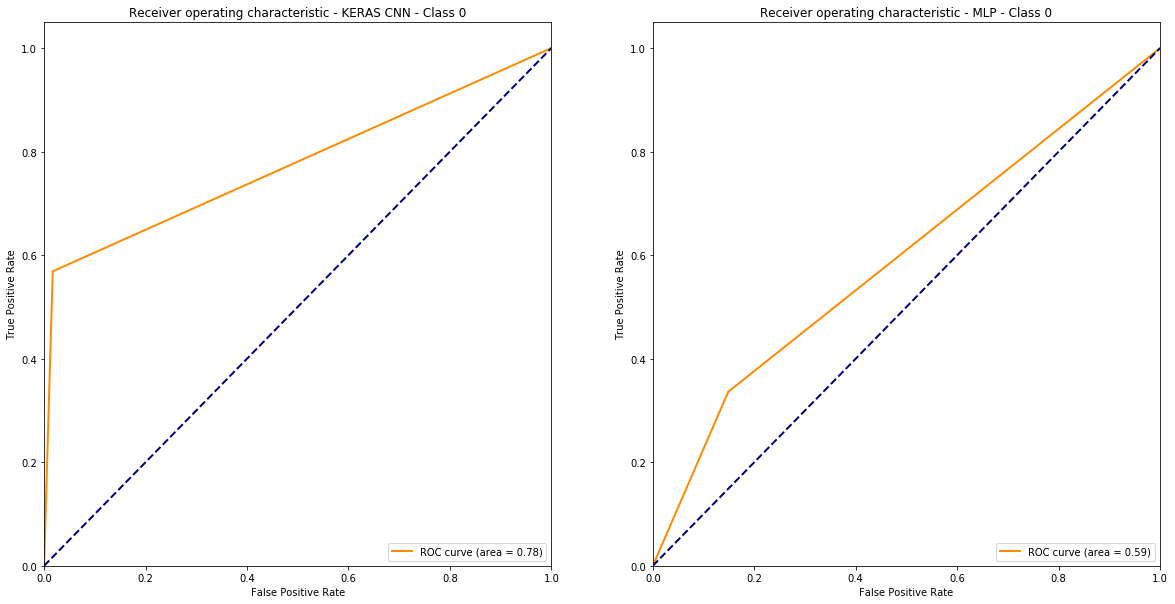

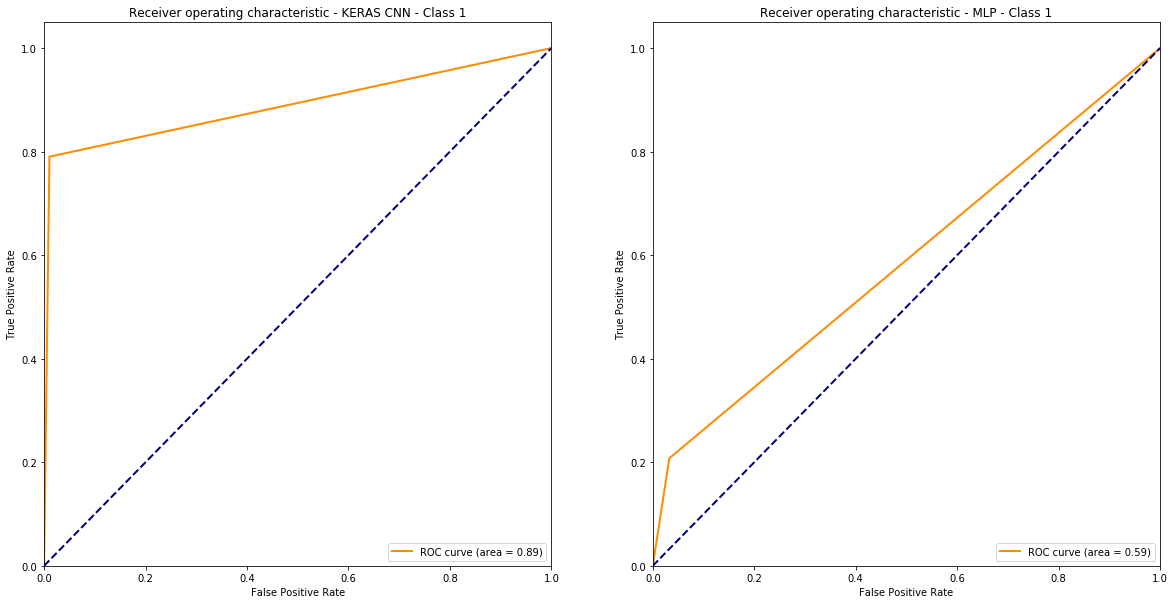

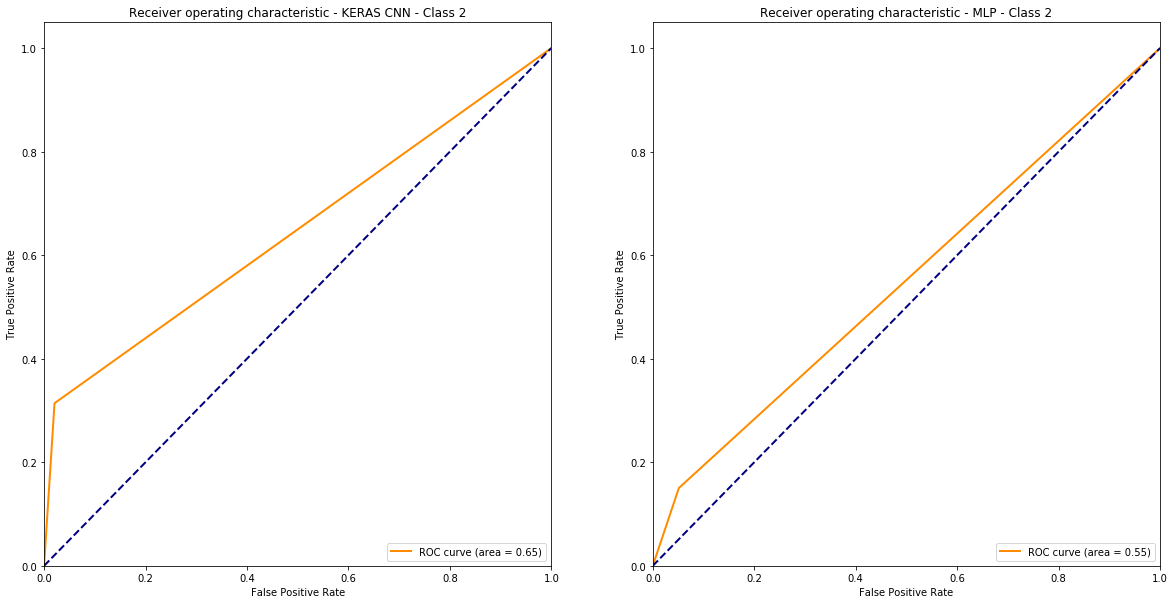

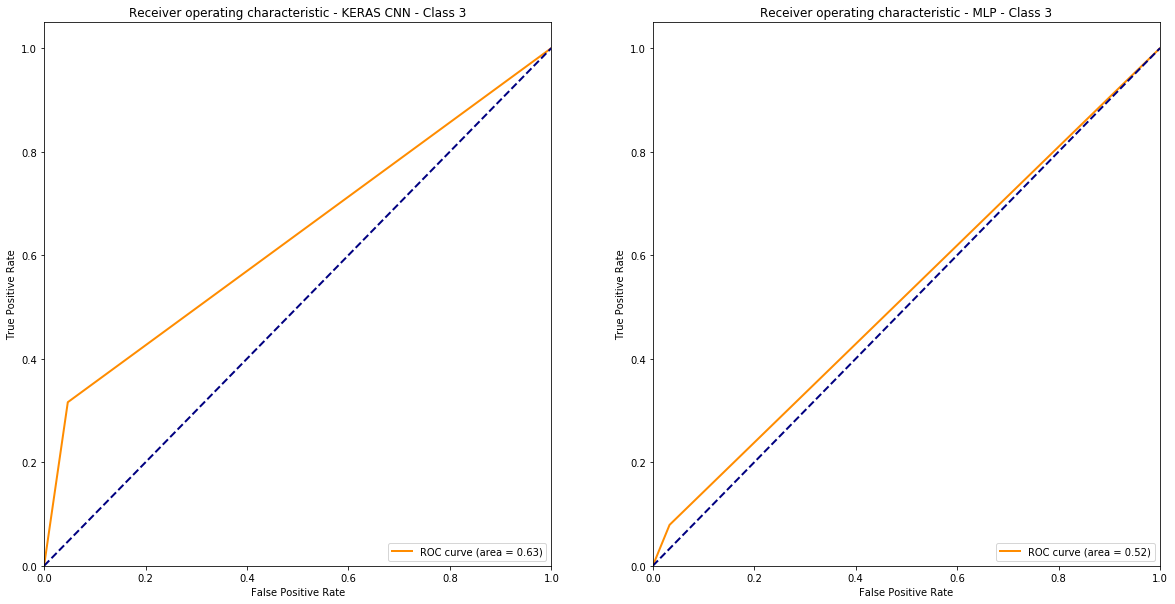

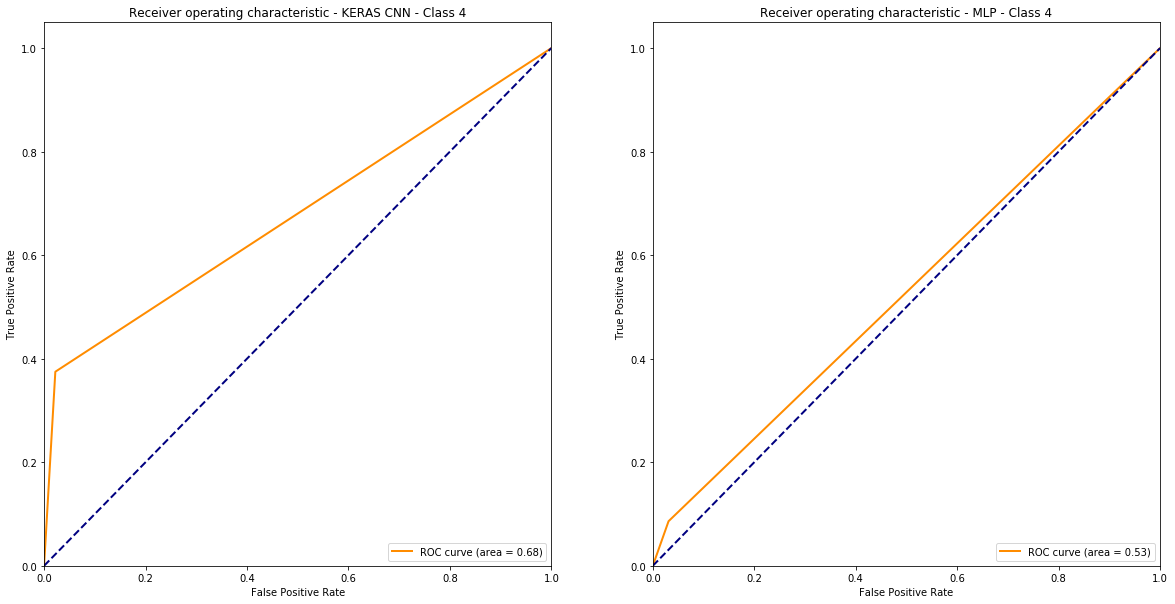

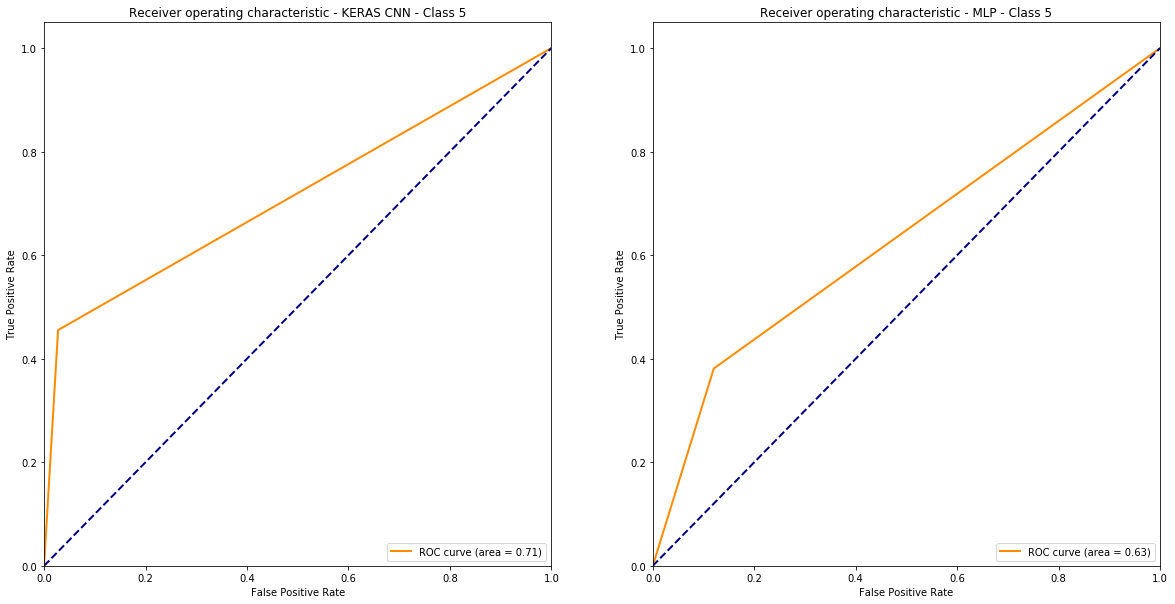

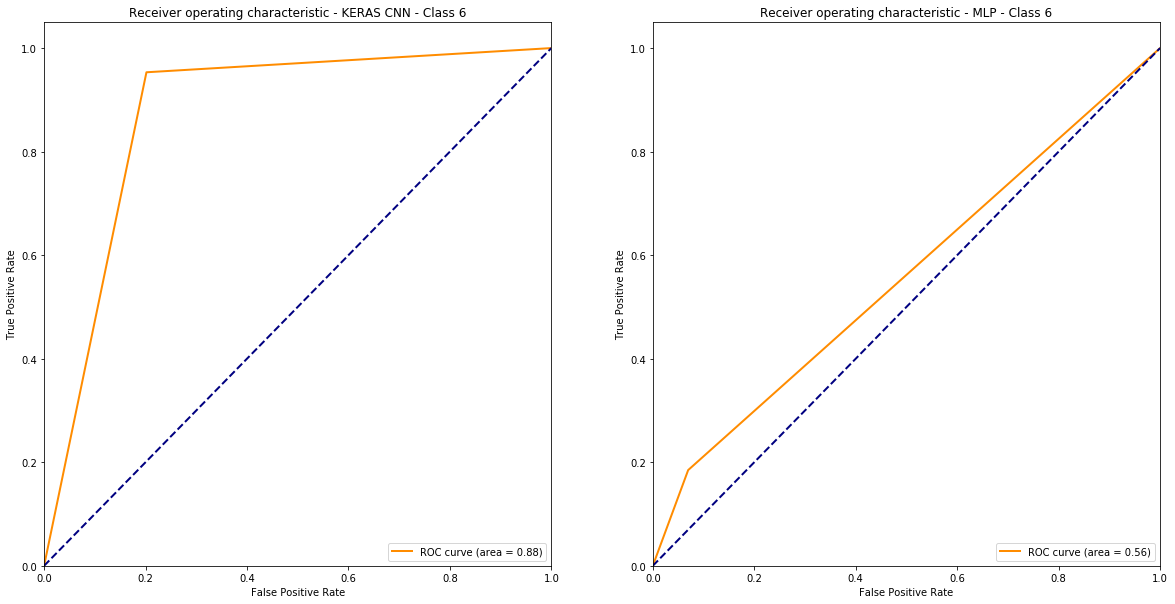

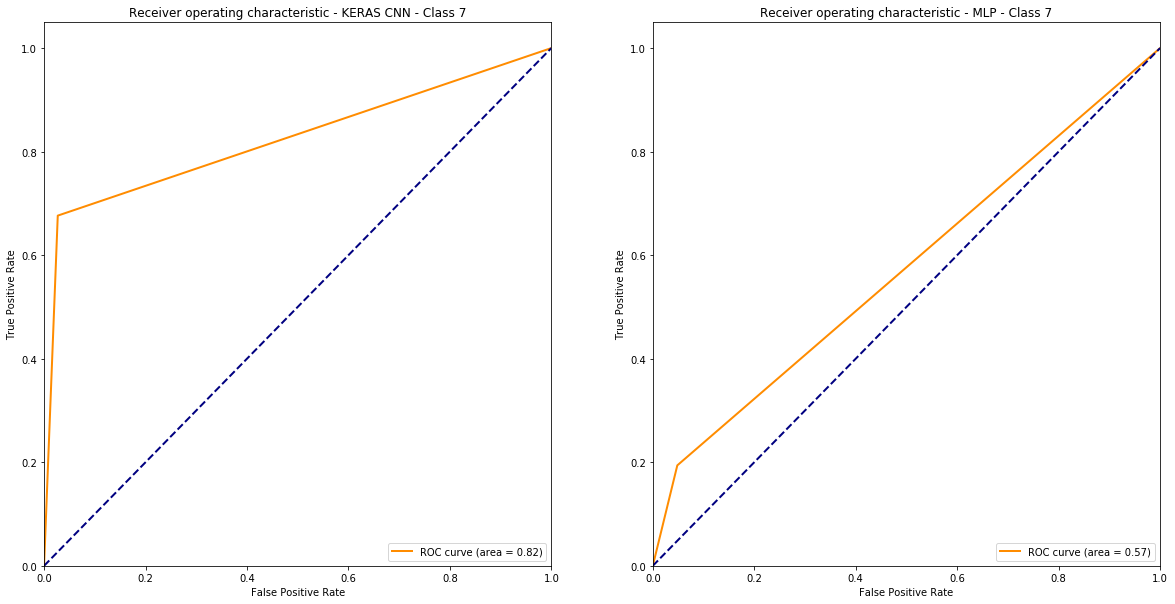

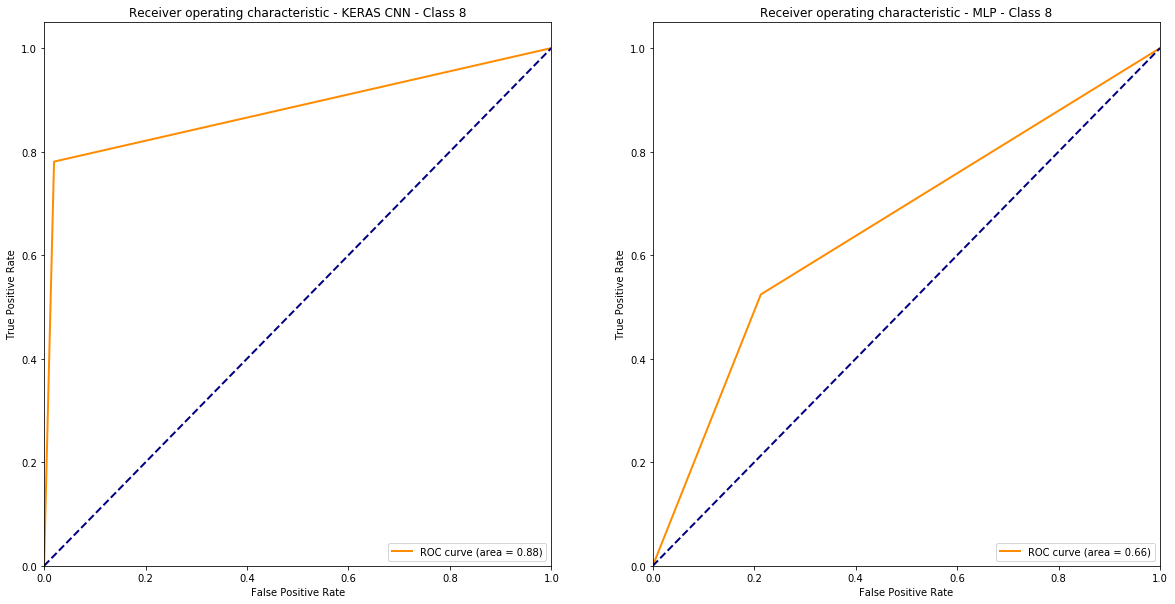

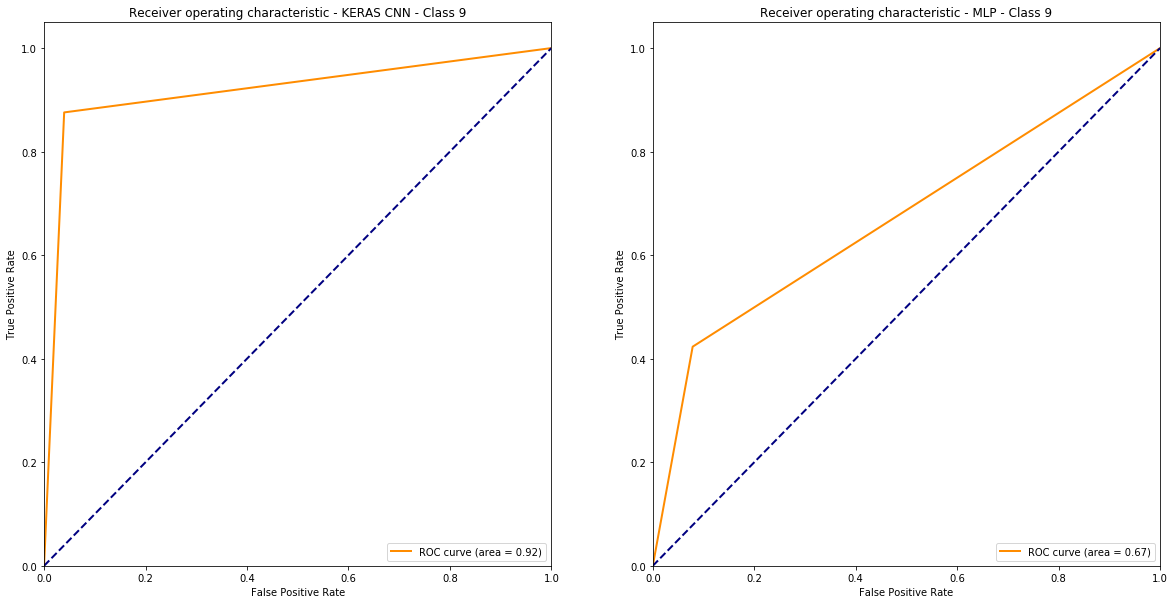

In [458]:
# Looping to create the binary predictions to plot the ROC and evluate the area under it
for i in range(n_classes):
    fpr_cnn, tpr_cnn, _ = roc_curve(y_test==i, yhat_cnn==i)
    fpr_mlp, tpr_mlp, _ = roc_curve(y_test==i, yhat_mlp==i)    
    roc(fpr_cnn, tpr_cnn, fpr_mlp, tpr_mlp, i)

<p>It can be observed that the Keras CNN is a much better classifier than the MLP. Its overall accuracy is 65% compared to 25% given by the MLP. The receiver operating characteristic curves also show its superior performance in classifying each class of the dataset.</p>

<h3>Confusion Matrices</h3>

<p>Here I show the confusion matrices for both the Keras CNN and the MLP. Per class classification performance for the CNN is significantly better, as expected.</p>

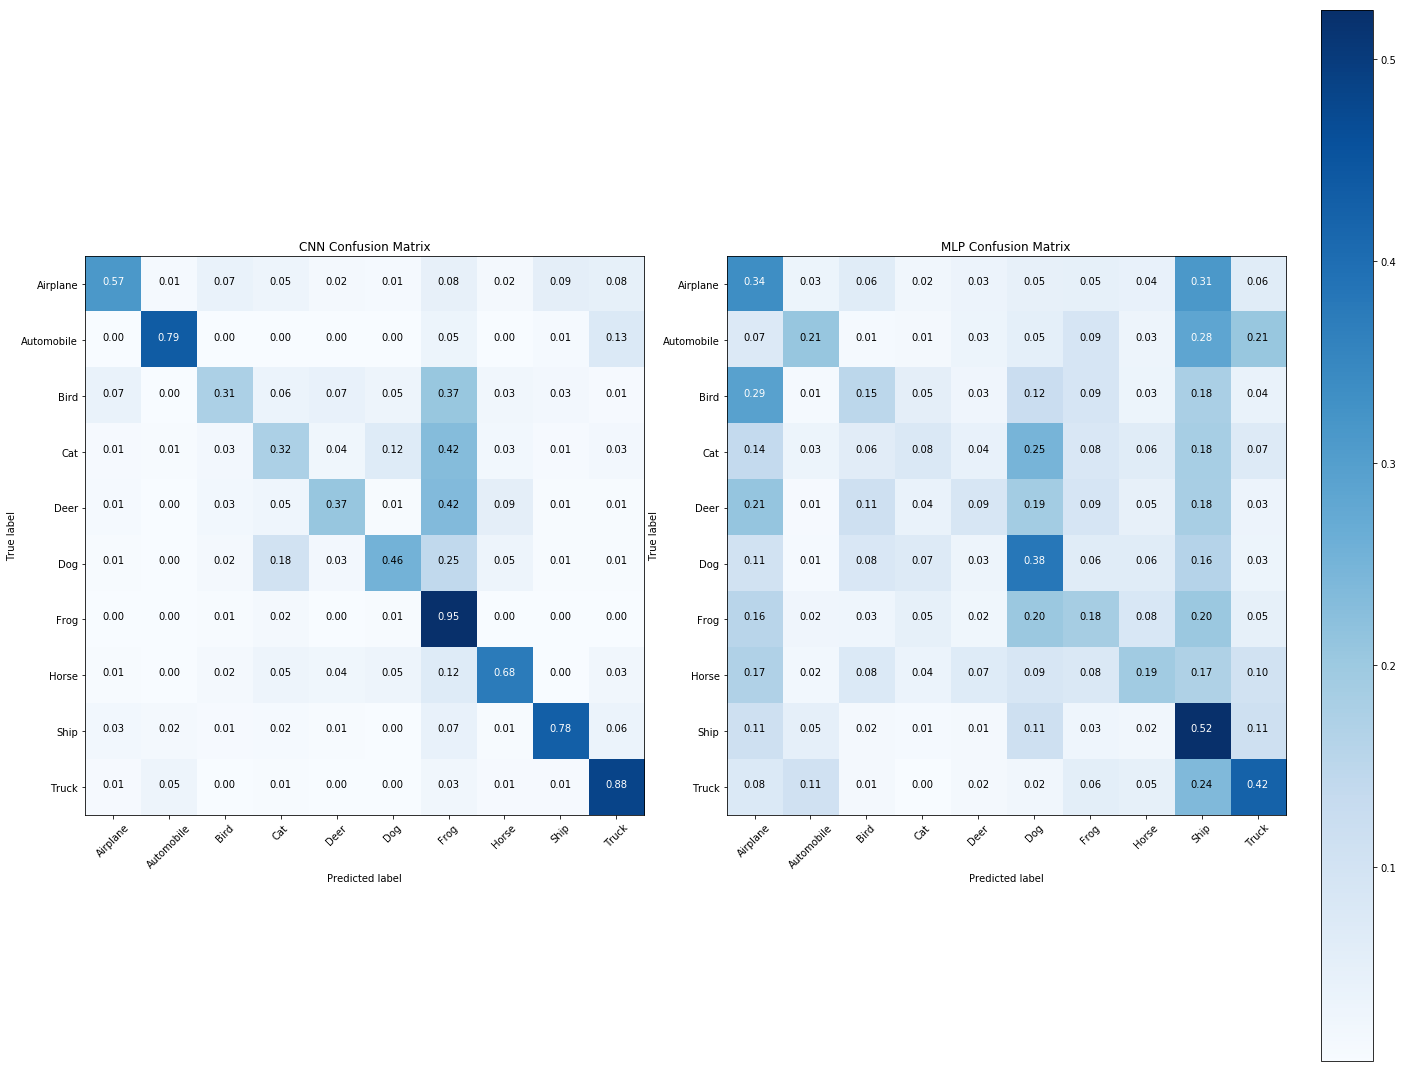

In [462]:
plt.figure(figsize = (20, 15))
plt.subplot(1, 2, 1)
plot_confusion_matrix(cf_cnn,labels, normalize=True,title='CNN Confusion Matrix',cmap=plt.cm.Blues)
plt.subplot(1, 2, 2)
plot_confusion_matrix(cf_mlp,labels, normalize=True,title='MLP Confusion Matrix',cmap=plt.cm.Blues)

<h1>Transfer Learning Using Xception</h1>
<p>In this section, I will be using the pre-trained weights of the Xception architecture to fit 1200 images (80%) and predict labels for 300 images (20%) of the cifar dataset. I do not do this for the whole dataset because I run out of memory when I try to resize 50,000 images.</p>

<h3>Data and Model</h3>
<p>
<ul>
    <li>Model: I am using the Xception model in this section, which was trained on the imagenet dataset.</li>
    <li>Data: I will be working with 1500 images to quantify the performance of the transfer model compared with a model that's been trained from scratch. I use 1500 images because of the heavy computational load needed when working with a larger subset. 80% of those 1500 images (1200) will be used in training the models, and the rest 20% (300) will be used for testing classification performance.</li>
    <li>Both models utilize categorical cross-entropy for the loss function and rmsprop for the optimizer. Also, they're trained on the same 1500 images.</li>
</ul>

</p>

In [31]:
from keras.datasets import cifar10
from keras.applications.xception import Xception
from keras.preprocessing import image
from keras.applications.resnet50 import preprocess_input, decode_predictions
import skimage.transform

In [32]:
width = 32
height = 32
image_count = 1500

# I shuffle the images of the dataset for later selection here
images_array = np.hstack((images, y.reshape((images.shape[0], 1))))
np.random.shuffle(images_array)
shuffled_images, image_labels = images_array[0:image_count, :-1].astype('float32'), images_array[0:image_count, -1].astype(int)
        
X_train, X_test, y_train, y_test = train_test_split(shuffled_images, image_labels, test_size = 0.2)

# Normalization
X_train_CNN = X_train/255
X_test_CNN = X_test/255
# Expanding the images into tensors that Keras understands
X_train_CNN = X_train_CNN.reshape((len(X_train_CNN), height, width, 3))
X_test_CNN = X_test_CNN.reshape((len(X_test_CNN), height, width, 3))
# One-hot-encoding the image labels
y_train_CNN = keras.utils.to_categorical(y_train, n_classes)
y_test_CNN = keras.utils.to_categorical(y_test, n_classes)

In [33]:
input_tensor = Input(shape=(299, 299, 3))
xCmodel = Xception(include_top=True, weights='imagenet', input_tensor = input_tensor)

<h3>Preparing the Data</h3>
<p>Here I resize the image data to the same dimensions of the images the original Xception model was trained on, which is 299x299.</p>

In [34]:
%%time
x_pre_train_up = [skimage.transform.resize(x, (299,299,3)) for x in X_train_CNN]
x_pre_train_up = np.stack(x_pre_train_up, axis=0)
print(x_pre_train_up.shape)

x_pre_test_up = [skimage.transform.resize(x, (299,299,3)) for x in X_test_CNN]
x_pre_test_up = np.stack(x_pre_test_up, axis=0)
print(x_pre_test_up.shape)

C:\Users\abdallah.jabr\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


(1200, 299, 299, 3)
(300, 299, 299, 3)
Wall time: 28.4 s


<h3>Compiling and Fitting the Transfer Model</h3>
<p>Here I add 2 dense layers, freeze the training of the Xception model, compile the model, fit my data, then find the predictions of my testing data using the transferred model.</p>

In [35]:
x = xCmodel.output
x = Dense(512, activation='relu', kernel_initializer='he_uniform')(x)
predictions = Dense(n_classes, activation='softmax', kernel_initializer='he_uniform')(x)

model = Model(inputs = xCmodel.input, output = predictions)

for layer in model.layers:
    layer.trainable = False

C:\Users\abdallah.jabr\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  """


In [36]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

In [37]:
%%time
data_generator = ImageDataGenerator(

    featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=False,
    rotation_range=9,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=3.0,
    zoom_range=0.3,
    channel_shift_range=0.,
    fill_mode='nearest',
    cval=0.,
    horizontal_flip=True,
    vertical_flip=False,
    rescale=None)

# Fitting the training data with the defined data generator
data_generator.fit(x_pre_train_up)
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
model.fit_generator(data_generator.flow(x_pre_train_up, y_train_CNN, batch_size=32), 
               steps_per_epoch=int(len(x_pre_train_up)/32),epochs=2, verbose=1)

Epoch 1/2
37/37 [==============================] - 1004s 27s/step - loss: 2.3021 - acc: 0.1056
Epoch 2/2
37/37 [==============================] - 996s 27s/step - loss: 2.3024 - acc: 0.1258
Wall time: 33min 24s


In [38]:
yhat = model.predict(x_pre_test_up)

In [48]:
transfer_testing_accu = accuracy_score(np.argmax(y_test_CNN, axis = 1), np.argmax(yhat, axis = 1))
print('The accuracy of the transfer model in classifying the testing data is:', transfer_testing_accu*100,'%')

The accuracy of the transfer model in classifying the testing data is: 7.666666666666666 %


<h3>Compiling and Fitting a Model from Scratch</h3>
<p>The following block of code defines a model from the first architecture I define at the begining of the notebook.</p>

In [41]:
l2_lambda = 0.0000001
cnn1 = Sequential()

cnn1.add(Conv2D(filters=32,
                input_shape = (width,height,3),
                kernel_size=(3,3), 
                padding='same', 
                kernel_regularizer=l2(l2_lambda),
                activation='relu'))

cnn1.add(Conv2D(filters=48,
                kernel_size=(3,3), 
                padding='same', 
                kernel_regularizer=l2(l2_lambda),
                activation='relu'))

cnn1.add(Conv2D(filters=64,
                kernel_size=(3,3), 
                kernel_regularizer=l2(l2_lambda),
                padding='same', 
                activation='relu'))

cnn1.add(MaxPooling2D(pool_size=(2, 2), data_format="channels_last"))

cnn1.add(Dropout(0.25))

cnn1.add(Conv2D(filters=64,
                kernel_size=(3,3),
                kernel_regularizer=l2(l2_lambda),
                padding='same', 
                activation='relu'))

cnn1.add(Conv2D(filters=64,
                input_shape = (width,height,1),
                kernel_size=(3,3), 
                kernel_regularizer=l2(l2_lambda),
                padding='same', 
                activation='relu'))

cnn1.add(MaxPooling2D(pool_size=(2, 2), data_format="channels_last"))

cnn1.add(Dropout(0.25))

cnn1.add(Flatten())

cnn1.add(Dense(512, activation='relu', kernel_regularizer=l2(l2_lambda)))
cnn1.add(Dropout(0.5))
cnn1.add(Dense(n_classes, activation='softmax', kernel_regularizer=l2(l2_lambda)))

In [44]:
X_train_S = X_train.reshape((1200, 32, 32, 3))
X_test_S = X_test.reshape((300, 32, 32, 3))

In [45]:
%%time
cnn1.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

data_generator = ImageDataGenerator(

    featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=False,
    rotation_range=9,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=3.0,
    zoom_range=0.3,
    channel_shift_range=0.,
    fill_mode='nearest',
    cval=0.,
    horizontal_flip=True,
    vertical_flip=False,
    rescale=None)

# Fitting the training data with the defined data generator
data_generator.fit(X_train_S)
cnn1.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
cnn1.fit_generator(data_generator.flow(X_train_S, y_train_CNN, batch_size=32), 
               steps_per_epoch=int(len(X_train_S)/32),
               epochs=5, 
               verbose=1)

yhat_cnn1 = cnn1.predict(X_test_S)

Epoch 1/5
37/37 [==============================] - 21s 560ms/step - loss: 14.4116 - acc: 0.1047
Epoch 2/5
37/37 [==============================] - 23s 612ms/step - loss: 14.3485 - acc: 0.1098
Epoch 3/5
37/37 [==============================] - 19s 501ms/step - loss: 14.3880 - acc: 0.1073
Epoch 4/5
37/37 [==============================] - 17s 469ms/step - loss: 14.4710 - acc: 0.1022
Epoch 5/5
37/37 [==============================] - 17s 459ms/step - loss: 14.3486 - acc: 0.1098
Wall time: 1min 39s


In [46]:
testing_accuracy = accuracy_score(np.argmax(y_test_CNN, axis = 1), np.argmax(yhat_cnn1, axis = 1))
print('The accuracy of the scratch model in classifying the testing data is:', testing_accuracy*100,'%')

The accuracy of the scratch model in classifying the testing data is: 10.666666666666668 %


<h3>Conclusion</h3>
<p>The accuracy for the transfer model in classifying the 300 testing images is 7.67%, while the accuracy for the developed model in classifying the same data is 10.67%. It took 33 minutes to fit 1200 images using the transfer model for two epcohs, while it took 1 minute and 39 seconds to fit the same images for 5 epochs using the developed model. I cannot with certainty say which one would perform better if the whole dataset was used for more epochs, as this would be very computationally heavy, but for the purpose of my dataset, I think it would be better to use models that are built specific for the dataset. My images (32x32 originally) had to be upsampled significantly to work with exception (at 299x299) and this is not exactly ideal. Also, the imagenet dataset is a million image dataset, so it is probably too general for my dataset.</p>